# <u> Content-based Filtering</u>


As an alternative to collaborative filtering explored in previous notebooks, **content-based filtering** relies on the intrinsic features of items rather than user–item interactions across the entire population. The main idea is to represent each movie as a **feature vector** capturing its attributes, and to construct a **user profile** by aggregating the features of movies the user has previously liked. The predicted preference for a new movie is then determined by the **similarity** between the user profile and the movie feature vector.

<br>

Mathematically, the predicted score for a user $u$ on an unseen movie $m$ can be expressed as

<br>

$$
\hat{r}_{u,m} = \text{scale}\Big(\text{sim}(\text{user\_profile}_u, \text{movie\_vector}_m)\Big)
$$

<br>

where  

- $\text{user\_profile}_u \in \mathbb{R}^d$ is the vector representing user $u$’s preferences;  
- $\text{movie\_vector}_m \in \mathbb{R}^d$ is the vector describing movie $m$;  
- $\text{sim}(\cdot,\cdot)$ is a similarity measure, such as **cosine similarity and dot product**;  
- $\text{scale}(\cdot)$ is a linear transformation that maps the similarity score to the rating range (0.5-5) by matching the original rating scale.  

<br>

This approach allows the recommender system to suggest movies that are **most similar to what the user already enjoys**. The method is particularly useful for capturing individual tastes, and handling situations where user interactions and overlapping with other users are limited. In practice, the quality of the recommendations depends mostly on the richness and relevance of the item features used to construct the user profile. 


## <u>0. Setting:</u>

### <u>0.1 Import libraries</u>

In [1]:
# Import necessary libraries
import pandas as pd, numpy as np, os, sys
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# Remove userwarnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Set the working directory
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

### <u>0.2 Import pre-built datasets</u>

As a comparative study with the memory-based and model-based collaborative system, we use the same **train–validation–test split** based on time. For each user, the **earliest 70% of their ratings** are used for training, the **next 10% for validation**, and the **most recent 20% for testing**. This ensures a fair comparison between different models without introducing bias in the evaluation set. Given the nature of the algorithm, which does not incorporate any content-based information about the movies, only the `userId`, `movieId`, and `rating` columns are used for training. Following the memory-based evaluation, RMSE is recorded on the full test set as well as separately for **warm-start** and **cold-start** subsets. Hyperparameter tuning is performed on the validation set, and total training and evaluation time is reported for computation comparison.



In [2]:
#Load dataframe over the columns of interest
train_df = pd.read_csv('../data/processed/train_df.csv')
val_df = pd.read_csv('../data/processed/val_df.csv')
test_df = pd.read_csv('../data/processed/test_df.csv')
warm_test_df = pd.read_csv('../data/processed/warm_test_df.csv')
cold_test_df = pd.read_csv('../data/processed/cold_test_df.csv')

In [3]:
train_df.head(3)

,userId,movieId,rating
0,27,2683,5.0
1,27,2997,3.0
2,27,1527,2.5


## <u>1. Similarity</u>



In this experiment, we use **cosine similarity** as the measure of similarity between the user profile and an unseen movie vector. The motivation for this choice lies in how cosine similarity emphasizes **alignment in feature space** rather than absolute magnitude. In this implementation, the user profile is constructed as a weighted aggregation of movie feature vectors, where the weights correspond to the ratings assigned by the user. Although this aggregation is normalized by the sum of the weights, the resulting vector may still exhibit differences in magnitude due to variations in how concentrated or diverse a user’s preferences are across feature dimensions. As a result, similarity measures that are sensitive to vector magnitude, such as the dot product, may assign systematically higher scores to users whose profiles have larger norms, regardless of how well the underlying feature patterns align.

Cosine similarity addresses this issue by normalizing both the user profile and the movie vector, effectively focusing on the **direction of the vectors rather than their scale**. This allows the model to compare how closely the feature composition of a movie matches the user’s preference profile, independently of the user’s overall activity level or rating intensity.

Mathematically, the cosine similarity between the user profile vector $\mathbf{u}$ and a movie feature vector $\mathbf{m}$ is defined as

<br>

$$
\text{sim}_{\text{cosine}}(\mathbf{u}, \mathbf{m}) = 
\frac{\mathbf{u} \cdot \mathbf{m}}{\|\mathbf{u}\| \, \|\mathbf{m}\|}
$$

where $\|\cdot\|$ denotes the **Euclidean norm** of a vector.

## <u>2. Movie Vector</u>

Based on the exploratory data analysis conducted in `01_eda.ipynb`, several features have been identified for inclusion in our movie vector representation. In this notebook, the following features are implemented:

- **Movie genres**: The 19 distinct genres are encoded using **one-hot encoding**, providing a categorical representation of the movie type.
- **Bayesian-adjusted rating**: This measure is included to capture the overall quality and community appraisal of a movie. It is preferred over the simple average rating, as it accounts for differences in popularity, exposure, and review count, thereby mitigating the influence of movies with very few ratings.
- **Decade of release**: The decade is derived from the release year to provide a coarse temporal context. This feature allows movies to be compared in terms of their production period, capturing similarity across time.
- **Year of release**: The year is extracted directly from the movie title and provides a more precise temporal context.
- **Tag relevance scores**: User-provided tags are incorporated as an additional source of content information. Given the large number of distinct tags (1128), variance-based filtering followed by **PCA** is applied to reduce dimensionality while retaining the most informative components for movie comparison.
- **Popularity**: The number of reviews is used to represent movie popularity. This feature captures the tendency of most users to watch widely-known movies while also allowing differentiation for those with niche tastes.

This combination of categorical, numerical, and derived features forms the basis of our content-based movie representation, resulting in a rich and compact vector space for similarity computation. To prevent features with different units or magnitudes from disproportionately influencing similarity measures, feature standardization is applied separately to each feature group prior to vector concatenation.


### <u> 1.1 General metrics and genre </u>

As a first step, we construct and extract general movie-level features such as release year, decade, genre, popularity and Bayesian-adjusted rating. These features are computed exclusively from the training set to avoid any information leakage from the validation and test sets. The full procedure is implemented in the `01_eda.ipynb` notebook, which serves as a reference for both reproducibility and more detailed exploratory analysis.

In [4]:
# Unique movie IDs
train_movie_ids = set(train_df['movieId'].unique())
val_movie_ids = set(val_df['movieId'].unique())
test_movie_ids = set(test_df['movieId'].unique())

# Movies in val/test that are NOT in train by set difference
val_only_movies = val_movie_ids - train_movie_ids
test_only_movies = test_movie_ids - train_movie_ids
print(f"\nMovies in validation but not in training: {len(val_only_movies)}")
print(f"Movies in test but not in training: {len(test_only_movies)}")


# Print movieIds that are in val/test but not in train
val_test_overlap = val_only_movies & test_only_movies
print(f"Movies in both validation and test but not in training: {len(val_test_overlap)}")


Movies in validation but not in training: 2
Movies in test but not in training: 4
Movies in both validation and test but not in training: 2


Given the nature of the algorithm and the use of Bayesian-adjusted ratings computed over the training set, we verified that all movies in the validation and test sets are also present in the training set. However, a total of 4 movies do not meet this condition. To include these movies in the creation of the movie vectors, we assign them the average Bayesian-adjusted rating computed over the training set. This approach allows us to handle a very cold-start scenario during evaluation while maintaining comparability across models by preserving the original validation and test sets. Similarly, the number of reviews for movies not present in the training set is set to 0.


In [5]:
# Import movies dataframe
movies_df = pd.read_csv('../data/processed/movies.csv')

# Extract movie year from title as column and format it as integer
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)').astype(float)

# Build decade column based on year
movies_df['decade'] = (movies_df['year'] // 10 * 10).astype('Int64')

# Build one-hot ecnoded genres
genres_dummies = movies_df['genres'].str.get_dummies(sep='|')

# Add prefix 'g_' to genre columns
genres_dummies = genres_dummies.add_prefix('G_')

# Concatenate the original movies_df with the genres_dummies
movies_df = pd.concat([movies_df, genres_dummies], axis=1)
movies_df.drop(columns=['genres'], inplace=True)
movies_df.drop(columns=['title'], inplace=True)

movies_df.head(3)

,movieId,year,decade,G_Action,G_Adventure,G_Animation,G_Children,G_Comedy,G_Crime,G_Documentary,...,G_Film-Noir,G_Horror,G_IMAX,G_Musical,G_Mystery,G_Romance,G_Sci-Fi,G_Thriller,G_War,G_Western
0,1,1995.0,1990,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995.0,1990,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995.0,1990,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:

# Group movies by movieId: count and average rating
movie_stats = train_df.groupby('movieId').agg({'rating': ['count', 'mean']})
movie_stats.columns = ['rating_count', 'average_rating']
movie_stats = movie_stats.reset_index()

# Global averages from TRAINING set
m = movie_stats['rating_count'].mean()      
C = movie_stats['average_rating'].mean()

# Compute Bayesian-adjusted rating for each movie in the traininig set
movie_stats['Bayes_rating'] = (
    (movie_stats['rating_count'] / (movie_stats['rating_count'] + m)) * movie_stats['average_rating']
    + (m / (movie_stats['rating_count'] + m)) * C
)


movie_stats.head(3)

,movieId,rating_count,average_rating,Bayes_rating
0,1,1774,3.883878,3.854467
1,2,691,3.132417,3.149043
2,3,410,3.169512,3.188785


In [7]:
# Left join movies_df over movie_stats on movieId
movies_vector = pd.merge(
    movies_df,
    movie_stats,
    on='movieId',
    how='left'
)

# Rename rating_count to popularity
movies_vector.rename(columns={'rating_count': 'popularity'}, inplace=True)

# Drop average_rating column
movies_vector.drop(columns=['average_rating'], inplace=True)

movies_vector.head(2)

,movieId,year,decade,G_Action,G_Adventure,G_Animation,G_Children,G_Comedy,G_Crime,G_Documentary,...,G_IMAX,G_Musical,G_Mystery,G_Romance,G_Sci-Fi,G_Thriller,G_War,G_Western,popularity,Bayes_rating
0,1,1995.0,1990,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1774.0,3.854467
1,2,1995.0,1990,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,691.0,3.149043


In [8]:
# Number of rows containing at least one NaN
rows_with_nan = movies_vector.isna().any(axis=1).sum()

# Total number of NaNs in the entire DataFrame
total_nans = movies_vector.isna().sum().sum()

print(f"Rows with at least one NaN: {rows_with_nan}")
print(f"Total NaNs in DataFrame: {total_nans}")

# Fill NaN values in popularity to 0
movies_vector['popularity'] = movies_vector['popularity'].fillna(0)

#Fill NaN values in Bayes_rating to the global bayesian average
mean_bayesian_rating = movies_vector['Bayes_rating'].mean()
movies_vector['Bayes_rating'] = movies_vector['Bayes_rating'].fillna(mean_bayesian_rating)

# Check for remaining NaN values
nan_counts = movies_vector.isna().sum().sum()
print(f"\nNumber of NaN values after filling: {nan_counts}")


Rows with at least one NaN: 4
Total NaNs in DataFrame: 8

Number of NaN values after filling: 0


### <u>1.2 Relevance score of tags</u>

As previously explained, the 1128 user-provided tags are first filtered based on the variance of their relevance scores, sorted in descending order. The purpose of this initial subsetting is twofold. First, it removes tags that appear frequently across most movies but provide little discriminatory or explanatory power for distinguishing between movies. Second, it filters out extremely rare tags that are only associated with a few movies and are unlikely to contribute meaningfully to overall similarity computations. To balance these considerations, we retain the top 50% of tags by variance. These selected tags are then processed using **Principal Component Analysis (PCA)** for further dimensionality reduction, following the variance-explained principle. This step ensures that the final tag representation captures the most informative patterns while reducing the dimensionality, making it suitable for integration with the other features in the `movies_vector`.


In [18]:
# Import genome_scores
genome_scores = pd.read_csv('../data/processed/genome_scores.csv')
genome_scores.head(3)

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775


In [19]:
# Find 50% tagId with most variance across moviesId
tag_variances = genome_scores.groupby('tagId')['relevance'].var()
top_50_percent_tags = tag_variances.nlargest(int(len(tag_variances) * 0.5)).index

# Filter genome_scores to keep only top 60% tags
filtered_genome_scores = genome_scores[genome_scores['tagId'].isin(top_50_percent_tags)]

In [20]:
# Compare distinct tagIds before and after filtering
before_tags = genome_scores['tagId'].nunique()
after_tags = filtered_genome_scores['tagId'].nunique()
print(f"Distinct tagIds before filtering: {before_tags}")
print(f"Distinct tagIds after filtering: {after_tags}")

Distinct tagIds before filtering: 1128
Distinct tagIds after filtering: 564


In [21]:
# Pivot the filtered genome_scores to create movie-tag matrix
movie_tag_matrix = filtered_genome_scores.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)
movie_tag_matrix.head(2)

tagId,5,8,9,12,13,18,19,20,21,22,...,1101,1103,1104,1108,1114,1116,1119,1121,1123,1126
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.14675,0.26275,0.26200,0.11625,0.18800,0.11050,0.6705,0.18450,0.33025,0.2825,...,0.2585,0.02775,0.29925,0.7370,0.77675,0.11275,0.03950,0.04575,0.1250,0.03625
2,0.11025,0.10975,0.09925,0.08900,0.22575,0.18975,0.6460,0.40025,0.45100,0.6020,...,0.1570,0.02400,0.31600,0.2445,0.18000,0.14750,0.04175,0.01725,0.1255,0.01475


In [22]:
# Range of k components to test
k_range = range(1,after_tags+1)
k_range_progress = after_tags//10

cumulative_variances = []

# Loop over k values to compute cumulative variance explained
for k in k_range:
    pca = PCA(n_components=k)
    pca.fit(movie_tag_matrix)
    cumulative_variances.append(np.sum(pca.explained_variance_ratio_))
    if k % k_range_progress == 0:
        print(f"Computed PCA for k={k}")


Computed PCA for k=56
Computed PCA for k=112
Computed PCA for k=168
Computed PCA for k=224
Computed PCA for k=280
Computed PCA for k=336
Computed PCA for k=392
Computed PCA for k=448
Computed PCA for k=504
Computed PCA for k=560


In [23]:
# Find the optimal k where cumulative variance explained >= 90%, 95%, 97.5%
optimal_k_87_5 = next((k for k, var in zip(k_range, cumulative_variances) if var >= 0.875), None)
optimal_k_90 = next((k for k, var in zip(k_range, cumulative_variances) if var >= 0.9), None)
optimal_k_95 = next((k for k, var in zip(k_range, cumulative_variances) if var >= 0.95), None)
optimal_k_97_5 = next((k for k, var in zip(k_range, cumulative_variances) if var >= 0.975), None)

print(f"\nOptimal k where cumulative variance explained >= 87.5%: {optimal_k_87_5}")
print(f"Optimal k where cumulative variance explained >= 90%: {optimal_k_90}")
print(f"Optimal k where cumulative variance explained >= 95%: {optimal_k_95}")
print(f"Optimal k where cumulative variance explained >= 97.5%: {optimal_k_97_5}")


Optimal k where cumulative variance explained >= 87.5%: 105
Optimal k where cumulative variance explained >= 90%: 140
Optimal k where cumulative variance explained >= 95%: 258
Optimal k where cumulative variance explained >= 97.5%: 358


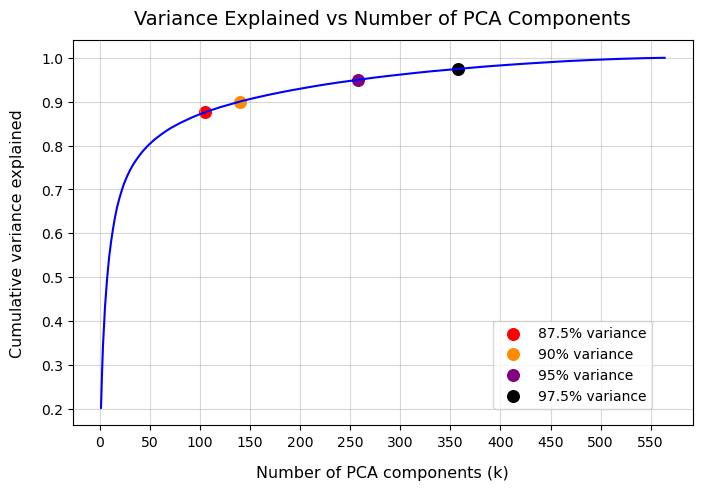

In [121]:
# Plot cumulative variance explained
plt.figure(figsize=(8,5))
plt.plot(k_range, cumulative_variances, color='blue')

# Highlight optimal k points with markers
plt.scatter(optimal_k_87_5, cumulative_variances[optimal_k_87_5-1], color='red', s=70, label='87.5% variance', marker='o')
plt.scatter(optimal_k_90, cumulative_variances[optimal_k_90-1], color='#FF8C00', s=70, label='90% variance', marker='o')
plt.scatter(optimal_k_95, cumulative_variances[optimal_k_95-1], color='#800080', s=70, label='95% variance', marker='o')
plt.scatter(optimal_k_97_5, cumulative_variances[optimal_k_97_5-1], color='black', s=70, label='97.5% variance', marker='o')

# Add labels and formatting
plt.xlabel('Number of PCA components (k)', labelpad=11.5, fontsize=11.5)
plt.ylabel('Cumulative variance explained', labelpad=11.5, fontsize=11.5)
plt.title('Variance Explained vs Number of PCA Components', pad=11.5, fontsize=14)
plt.grid(True, alpha=0.5)
plt.xticks(ticks=range(0, max(k_range)+1, 50))
plt.yticks(ticks=np.arange(0.2, max(cumulative_variances)+ 0.01, 0.1))
plt.legend( bbox_to_anchor=(0.945, 0.29))
# Save the plot
plt.savefig('../notebooks/images/pca_cumulative_variance.png', dpi=300)
plt.show()


**<u>Comment:</u>**

Under the principle of parsimony and for the purpose of data reduction in our tag relevance representation, we opt for `k = 140`, which captures approximately 90%% of the variance in the original matrix. While this results in a loss of about 10% of the total variance (excluding the information already filtered out in the initial variance-based subsetting), it allows us to obtain a more compact and expressive movie vector that can be more efficiently handled during training and evaluation.


In [52]:
# Save reduced-matrix with optimal k=140
pca_final = PCA(n_components=140)
reduced_matrix = pca_final.fit_transform(movie_tag_matrix)

# Create DataFrame for reduced matrix with appropriate column names
reduced_matrix_df = pd.DataFrame(reduced_matrix, 
                                 index=movie_tag_matrix.index, 
                                 columns=[f'tagPCA_{i}' for i in range(reduced_matrix.shape[1])])

reduced_matrix_df.head(2)


,tagPCA_0,tagPCA_1,tagPCA_2,tagPCA_3,tagPCA_4,tagPCA_5,tagPCA_6,tagPCA_7,tagPCA_8,tagPCA_9,...,tagPCA_130,tagPCA_131,tagPCA_132,tagPCA_133,tagPCA_134,tagPCA_135,tagPCA_136,tagPCA_137,tagPCA_138,tagPCA_139
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.479407,0.768443,2.561891,0.588937,1.500347,1.264237,-0.201285,1.583438,0.884729,-1.389821,...,0.150961,0.123814,0.006364,-0.060180,0.035794,-0.001402,-0.159601,0.109512,0.007019,-0.096806
2,-1.664443,0.721792,1.424556,0.603805,0.098422,0.334052,-0.300475,1.158237,0.291064,-0.970593,...,-0.159753,0.045773,-0.041750,0.013686,-0.230820,0.041065,-0.031913,0.134024,-0.122325,-0.060330


In [53]:
# Left join movies_vector with reduced_matrix_df on movieId
movies_vector_complete = movies_vector.merge(
    reduced_matrix_df,
    left_on='movieId',
    right_index=True,
    how='left'
)

movies_vector_complete.head(2)

,movieId,year,decade,G_Action,G_Adventure,G_Animation,G_Children,G_Comedy,G_Crime,G_Documentary,...,tagPCA_130,tagPCA_131,tagPCA_132,tagPCA_133,tagPCA_134,tagPCA_135,tagPCA_136,tagPCA_137,tagPCA_138,tagPCA_139
0,1,1995.0,1990,0,1,1,1,1,0,0,...,0.150961,0.123814,0.006364,-0.060180,0.035794,-0.001402,-0.159601,0.109512,0.007019,-0.096806
1,2,1995.0,1990,0,1,0,1,0,0,0,...,-0.159753,0.045773,-0.041750,0.013686,-0.230820,0.041065,-0.031913,0.134024,-0.122325,-0.060330


In [57]:
# check for NaN values in movies_vector_std
nan_counts_movies_vector_std = movies_vector_complete.isna().sum()
print("NaN counts in movies_vector_std:\n", nan_counts_movies_vector_std[nan_counts_movies_vector_std > 0])

# Count number of rows with at least one NaN in user_vectors
n_rows_with_nan = movies_vector_complete.isna().any(axis=1).sum()
print(f"\nNumber of rows with at least one NaN in movies_vector_complete: {n_rows_with_nan}")

NaN counts in movies_vector_std:
 tagPCA_0      35
tagPCA_1      35
tagPCA_2      35
tagPCA_3      35
tagPCA_4      35
              ..
tagPCA_135    35
tagPCA_136    35
tagPCA_137    35
tagPCA_138    35
tagPCA_139    35
Length: 140, dtype: int64

Number of rows with at least one NaN in movies_vector_complete: 35


The remaining missing values correspond to 35 movies for which all tag-related information was removed during variance-based filtering due to their niche nature. As a result, no tag signal remains after the PCA projection, leading to undefined component values. These entries are filled with zero to preserve evaluation stability. Since PCA is mean-centered, this choice represents the absence of tag information rather than the introduction of spurious signal and is unlikely to affect the overall results given the small proportion of affected movies.

In [58]:
# Fill NaNs with zeros for movies that had no tag info in PCA
movies_vector_complete.fillna(0, inplace=True)

### <u>1.3 Standardization of columns</u>

Due to the different nature of certain variables such as year, decade, popularity, and Bayesian-adjusted rating, standardization is applied to each column by centering around the mean and dividing by the standard deviation. This ensures that all features have comparable magnitudes and behave well during similarity computation. In contrast, one-hot encoded genres do not require standardization, as their dummy structure is already suitable for similarity measures. The PCA components are also left as-is, since they are already centered and provide an expressive, structured representation with magnitudes comparable to the other standardized variables.


In [59]:
# Stanadrdize year, decade, popularity, Bayes_rating
scaler = StandardScaler()
movies_vector_complete[['year', 'decade', 'popularity', 'Bayes_rating']] = scaler.fit_transform(
    movies_vector_complete[['year', 'decade', 'popularity', 'Bayes_rating']]
)

# Save the final movies_vector_complete dataframe
movies_vector_complete.to_csv('../data/processed/movies_vector_std.csv', index=False)



In [60]:
movies_vector_std = pd.read_csv('../data/processed/movies_vector_std.csv', index_col=0)
movies_vector_std.head(2)

,year,decade,G_Action,G_Adventure,G_Animation,G_Children,G_Comedy,G_Crime,G_Documentary,G_Drama,...,tagPCA_130,tagPCA_131,tagPCA_132,tagPCA_133,tagPCA_134,tagPCA_135,tagPCA_136,tagPCA_137,tagPCA_138,tagPCA_139
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.162763,0.136589,0,1,1,1,1,0,0,0,...,0.150961,0.123814,0.006364,-0.060180,0.035794,-0.001402,-0.159601,0.109512,0.007019,-0.096806
2,0.162763,0.136589,0,1,0,1,0,0,0,0,...,-0.159753,0.045773,-0.041750,0.013686,-0.230820,0.041065,-0.031913,0.134024,-0.122325,-0.060330


## <u>2. User Vector</u>

Given the preparation of the movie vectors, building the user vector representation is straightforward. For each user, we compute a weighted average of the movie vectors for the movies they have rated, where the weights are the **user-centered ratings**. Specifically, the user vector $\mathbf{u}_i$ for user $i$ is calculated as:

<br>

$$
\mathbf{u}_i = \frac{\sum_{j \in M_i} (r_{ij} - \bar{r}_i) \, \mathbf{v}_j}{\sum_{j \in M_i} |r_{ij} - \bar{r}_i|}
$$

where:

- $M_i$ is the set of movies rated by user $i$ in the training set
- $r_{ij}$ is the rating given by user $i$ to movie $j$  
- $\bar{r}_i$ is the mean rating of user $i$ across all rated movies in the training set
- $\mathbf{v}_j$ is the movie vector for movie $j$  

<br>

The decision to **center the ratings** for each user is motivated by the principle of **user bias correction**. Different users may systematically give higher or lower ratings, and centering ensures that the user vector reflects the **relative preference of a user** rather than their absolute rating scale. This helps produce more accurate similarity measures and better predictions in content-based filtering.


In [61]:
# Compute mean rating per user
user_means = train_df.groupby('userId')['rating'].mean()

# Assign mean ratings to users

# Build centered rating column to train_df
train_df = train_df.copy()
train_df['ratintg_centered'] = train_df['rating'] - train_df['userId'].map(user_means)

# Inner join train_df with movies_vector_std on movieId
train_df_with_vectors = train_df.merge(
    movies_vector_std,
    left_on='movieId',
    right_index=True,
    how='inner'
)

train_df_with_vectors.head(2)

,userId,movieId,rating,ratintg_centered,year,decade,G_Action,G_Adventure,G_Animation,G_Children,...,tagPCA_130,tagPCA_131,tagPCA_132,tagPCA_133,tagPCA_134,tagPCA_135,tagPCA_136,tagPCA_137,tagPCA_138,tagPCA_139
0,27,2683,5.0,1.170213,0.394642,0.136589,1,1,0,0,...,-0.023269,0.053601,0.096303,-0.077775,-0.059584,0.095635,-0.04302,-0.079276,-0.031259,-0.106952
575,54,2683,4.0,0.603239,0.394642,0.136589,1,1,0,0,...,-0.023269,0.053601,0.096303,-0.077775,-0.059584,0.095635,-0.04302,-0.079276,-0.031259,-0.106952


In [63]:
# Select all the features columns from movies_vector_std
features_columns =  movies_vector_std.columns

# Multiply each feature by the centered rating per user by row
weighted_features = train_df_with_vectors[features_columns].multiply(train_df_with_vectors['ratintg_centered'], axis=0)

# Numerator by summing weighted features within userId
user_numerators = weighted_features.groupby(train_df_with_vectors['userId']).sum()

# Denominator by summing absolute centered ratings within userId
user_denominators = train_df_with_vectors.groupby('userId')['ratintg_centered'].apply(lambda x: x.abs().sum())

# User profiles by dividing numerators by denominators
user_vectors = user_numerators.div(user_denominators, axis=0)

# Replace NaNs caused by zero denominator with 0 in users with no rating variance
user_vectors = user_vectors.fillna(0)

# Concatenate user means
user_vectors = pd.concat([user_vectors, user_means.rename('user_mean_rating')], axis=1)

# Save user_vectors to csv
user_vectors.to_csv('../data/processed/user_vectors.csv')

In [66]:
# Load and display user_vectors
user_vectors = pd.read_csv('../data/processed/user_vectors.csv', index_col=0)
user_vectors.head(2)

,year,decade,G_Action,G_Adventure,G_Animation,G_Children,G_Comedy,G_Crime,G_Documentary,G_Drama,...,tagPCA_131,tagPCA_132,tagPCA_133,tagPCA_134,tagPCA_135,tagPCA_136,tagPCA_137,tagPCA_138,tagPCA_139,user_mean_rating
userId,,,,,,,,,,,,,,,,,,,,,
27,-0.109584,-0.161600,-0.145213,-0.216041,-0.035252,-0.035252,0.093790,0.061125,0.005175,-0.018111,...,-0.007975,0.002317,-0.013155,0.005673,-0.001643,0.005531,-0.030357,-0.005475,-0.015788,3.829787
29,-0.054538,-0.049551,0.035144,0.016069,0.037736,0.019075,-0.081588,0.052872,-0.007361,0.058159,...,0.004910,0.015197,0.004592,0.012186,-0.004615,-0.018118,-0.012634,0.011520,0.008232,3.577236


## <u>3. Rating Prediction</u>

To translate the similarity between a user profile $\mathbf{v}_u$ and an unseen movie $\mathbf{v}_i$ into a predicted rating, we apply a **linear piecewise mapping**.  

The rationale behind this approach is to incorporate **user-specific bias** while ensuring that the predicted ratings stay within the original rating scale $[R_{\min}, R_{\max}]$.

1. **User-centered rating:** For each user, we first compute the mean rating $\bar{r}_u$ and center the ratings used to build the user profile. By doing so, we account for user tendencies to rate higher or lower than the general population.  

2. **Similarity computation:** The cosine similarity between the user vector and the movie vector is calculated as:

<br> 

$$
s_{u,i} = \text{cosine\_similarity}(\mathbf{v}_u, \mathbf{v}_i)
$$

<br>

3. **Piecewise linear mapping:** The similarity is then mapped back to the rating scale based on whether it is positive or negative:

<br>

$$
\hat{r}_{u,i} =
\begin{cases} 
\bar{r}_u + s_{u,i} \cdot (R_{\max} - \bar{r}_u), & s_{u,i} > 0 \\
\bar{r}_u + s_{u,i} \cdot (\bar{r}_u - R_{\min}), & s_{u,i} \le 0
\end{cases}
$$

<br>

- When the similarity is positive, the predicted rating moves above the user's mean toward the maximum rating.  
- When the similarity is negative, the predicted rating moves below the user's mean toward the minimum rating.  
- If the similarity is zero, the predicted rating remains equal to the user's mean.

<br>

This approach for mapping similarity into ratings was chosen for its **simplicity, interpretability, and effectiveness**, providing a strong baseline for content-based recommendation. It naturally integrates user bias while reflecting the degree of alignment between user preferences and the characteristics of unseen movies. Furthermore, since the cosine similarity ranges from $-1$ to $1$, no additional clipping is required: the piecewise multiplier inherently assigns the maximum predicted rating when the similarity reaches $1$ and the minimum when it reaches $-1$.



## <u>4. Hyperparameter tuning</u>

Hyperparameter tuning is performed over the validation set to evaluate the contribution of different subsets of features in predicting user ratings. The goal of this validation is to measure the **marginal effect** of each feature group and understand how much each component improves model performance.

To do so, we create the following **feature configurations** by subsetting the movie vectors:

- **movie_info:** Includes only the movie information.
- **movie_info_genres:** Includes only the movie information along with the 19 one-hot encoded genres.  
- **movie_info_tags:** Includes only the movie information along with the 150 PCA components extracted from the `genome_scores.csv`, representing the most relevant tag scores out of the initial 1128 tags.  
- **full_features:** Includes both genre and tag information, together with the movie information.

For reference, the **movie information** used in all settings is rigorously standardized and consists of:  
- `year` — the release year of the movie  
- `decade` — the decade derived from the release year  
- `popularity` — the natural logarithm of the number of reviews, reflecting how widely the movie is known  
- `Bayes_rating` — the Bayesian-adjusted rating computed over the training set, capturing overall movie quality while mitigating the effect of movies with very few ratings

By evaluating these configurations on the validation set, we can determine which feature groups contribute most to predictive accuracy and select the optimal combination for the final model.



In [83]:
# Build function content based evaluation

def predict_ratings(eval_df, user_vectors, movie_vectors, features='combined'):

    """
    Predict ratings for a val/test set based on user and movie vectors by computing RMSE on the evaluation set.

    Args:
        eval_df (pd.DataFrame): Must contain 'userId', 'movieId', 'rating'
        user_vectors (pd.DataFrame): index=userId, columns=all features + 'user_mean_rating'
        movie_vectors (pd.DataFrame): index=movieId, columns=all features
        features (str): 'movie_info', 'movie_info_genres', 'movie_info_tags', 'full_features' — determines which features to use

    Returns:
        float: RMSE
    
    """
    # stats
    if features == 'movie_info':
        user_feat = ['year', 'decade', 'popularity', 'Bayes_rating']
    
    # Genre(one-hot encoded) + stats
    elif features == 'movie_info_genres':
        user_feat = ['year', 'decade', 'popularity', 'Bayes_rating'] + [c for c in movie_vectors.columns if c.startswith('G_')]
    
    # Tag(PCA) + stats
    elif features == 'movie_info_tags':
        user_feat = ['year', 'decade', 'popularity', 'Bayes_rating'] + [c for c in movie_vectors.columns if c.startswith('tagPCA_')]

    else:  # stats + genre + tag
        user_feat = ['year', 'decade', 'popularity', 'Bayes_rating'] + \
                    [c for c in movie_vectors.columns if c.startswith('G_')] + \
                    [c for c in movie_vectors.columns if c.startswith('tagPCA_')]

    # Extract movie feature matrix on val/test set
    M = movie_vectors.loc[eval_df['movieId'], user_feat].values

    # Map userId to index in user_vectors
    user_idx = eval_df['userId'].map(lambda x: user_vectors.index.get_loc(x)).values
    U = user_vectors[user_feat].values[user_idx]

    # Compute norms and clip to avoid division by zero
    U_norm = np.linalg.norm(U, axis=1)
    M_norm = np.linalg.norm(M, axis=1)
    U_norm = np.where(U_norm == 0, 1e-8, U_norm)
    M_norm = np.where(M_norm == 0, 1e-8, M_norm)


    # Compute cosine similarity
    sims = np.sum(U * M, axis=1) / (U_norm * M_norm + 1e-8)


    # User mean rating for mapping similarity to predicted rating
    user_means = user_vectors.loc[eval_df['userId'], 'user_mean_rating'].values

    # Map similarity into rating (piecewise linear)
    R_min, R_max = 0.5, 5
    preds = np.where(
        sims > 0,
        user_means + sims * (R_max - user_means),
        user_means + sims * (user_means - R_min)
    )

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(eval_df['rating'], preds))

    return rmse


In [85]:
# Import user_vectors, movies_vector_std, val_df
user_vectors = pd.read_csv('../data/processed/user_vectors.csv', index_col=0)
movies_vector_std = pd.read_csv('../data/processed/movies_vector_std.csv', index_col=0)
val_df = pd.read_csv('../data/processed/val_df.csv')


In [88]:

# Evaluate different feature sets on validation set
feature_sets = ['movie_info', 'movie_info_genres', 'movie_info_tags', 'full_features']
val_results = {}
for features in feature_sets:
    
    rmse = predict_ratings(val_df, user_vectors, movies_vector_std, features=features)
    val_results[features] = rmse

    if features == 'full_features':
        print(f"Validation RMSE using all features: {rmse:.4f}")
    
    if features == 'movie_info':
        print(f"Validation RMSE using only movie metrics features: {rmse:.4f}")
    
    if features == 'movie_info_genres':
        print(f"Validation RMSE using movie metrics + genres features: {rmse:.4f}")
    
    if features == 'movie_info_tags':
        print(f"Validation RMSE using movie metrics + tags features: {rmse:.4f}")

Validation RMSE using only movie metrics features: 1.3386
Validation RMSE using movie metrics + genres features: 1.0881
Validation RMSE using movie metrics + tags features: 0.9582
Validation RMSE using all features: 0.9373


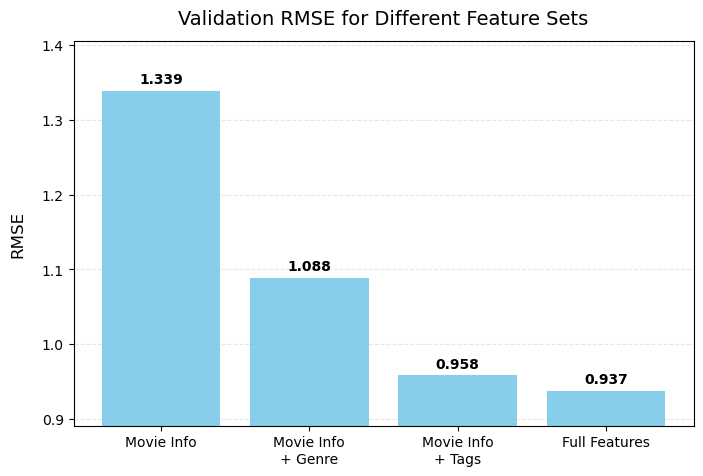

In [103]:
# Mapping feature keys into text label
label_mapping = {
    'movie_info': 'Movie Info',
    'movie_info_genres': 'Movie Info\n+ Genre',
    'movie_info_tags': 'Movie Info\n+ Tags',
    'full_features': 'Full Features'
}

# Prepare data
features = [label_mapping[f] for f in val_results.keys()]
rmse_values = list(val_results.values())

# Plot
plt.figure(figsize=(8,5))
plt.bar(features, rmse_values, color='skyblue')
plt.title("Validation RMSE for Different Feature Sets", pad=12, fontsize=14)
plt.ylabel("RMSE", labelpad=12, fontsize=12)
# plt.xlabel("Feature Set", labelpad=12, fontsize=)
plt.ylim(min(rmse_values)*0.95, max(rmse_values)*1.05)
for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold', fontsize=10)

plt.grid(axis='y', alpha=0.3, linestyle='--')

# Save the plot
plt.savefig('../notebooks/images/validation_rmse_feature_sets.png', dpi=300)

plt.show()


**<u>Commnent:</u>**

From the validation set, we can observe the marginal contribution of each feature group and how their combination provides the most informative vector representation for movies in the content-based model. As expected, tag-based features have a larger impact on predictive performance compared to genres. However, this should be interpreted with caution because the majority of movies are “warm” items, while a few receive little signal. During vector preparation, some movies had no PCA signal because their tags were filtered out by the variance cutoff. In these cases, genre features still provided useful information, helping to distinguish movie types where the PCA tags could not.

## <u>5.0 Model Evaluation </u>

In [80]:
#  Set optimal features based on validation results
optimal_features = 'combined'

# start time
start = time.perf_counter()

# Buffer 10 seconds to account for movie and vector construction time
time_buffer = 10

# evaluate on test set with optimal features
rmse_test = predict_ratings(test_df, user_vectors, movies_vector_std, features=optimal_features)
rmse_warm_test = predict_ratings(warm_test_df, user_vectors, movies_vector_std, features=optimal_features)
rmse_cold_test = predict_ratings(cold_test_df, user_vectors, movies_vector_std, features=optimal_features)

# end time
end = time.perf_counter()

# Elapsed time
elapsed_time = end - start + time_buffer

In [81]:
print(
    f"Model performance (content-based) on test set (using {optimal_features} features):\n"
    f"RMSE Total: {rmse_test:.4f}\n"
    f"RMSE Warm:  {rmse_warm_test:.4f}\n"
    f"RMSE Cold:  {rmse_cold_test:.4f}\n"
    f"Elapsed time: {elapsed_time:.1f} seconds"
)

Model performance (content-based) on test set (using combined features):
RMSE Total: 0.9422
RMSE Warm:  0.9430
RMSE Cold:  0.9286
Elapsed time: 12.3 seconds


## <u> 6.0 Summary of findings </u>

### <u>6.1 Model performance</u>

<table style="border-spacing:0; margin-bottom:15px;">
<tr>
<td style="text-align:center; padding:0;">
<img src="images/pca_cumulative_variance.png" width="598" height="450" style="display:block;"/>
</td>
<td style="width:20px;"></td> 
<td style="text-align:center; padding:0;">
<img src="images/validation_rmse_feature_sets.png" width="598" height="450" style="display:block;"/>
</td>
</tr>
</table>


<br>
<table border="1" cellpadding="5" cellspacing="0" style="text-align: center;">
  <tr>
    <th>Model Type</th>
    <th>Validation RMSE</th>
    <th colspan="3">Test RMSE</th>
    <th>Elapsed Time (s)</th>
  </tr>
  <tr>
    <th></th>
    <th>Total</th>
    <th>Total</th>
    <th>Warm</th>
    <th>Cold</th>
    <th></th>
  </tr>
  <tr>
    <td>Content-based Filtering</td>
    <td>0.9373</td>
    <td>0.9422</td>
    <td>0.9430</td>
    <td>0.9286</td>
    <td>12.3</td>
  </tr>
</table>


### <u> 6.2 Discussion </u>
